WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting models...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 429 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 398 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.


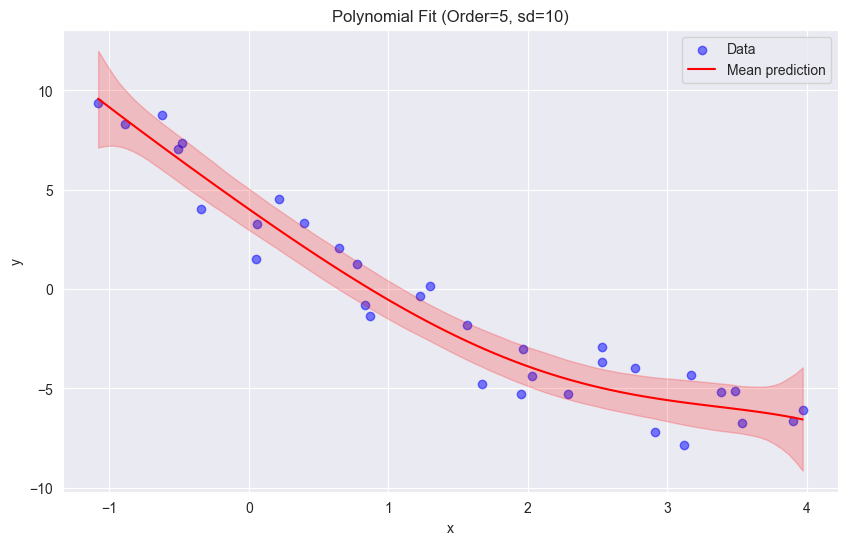

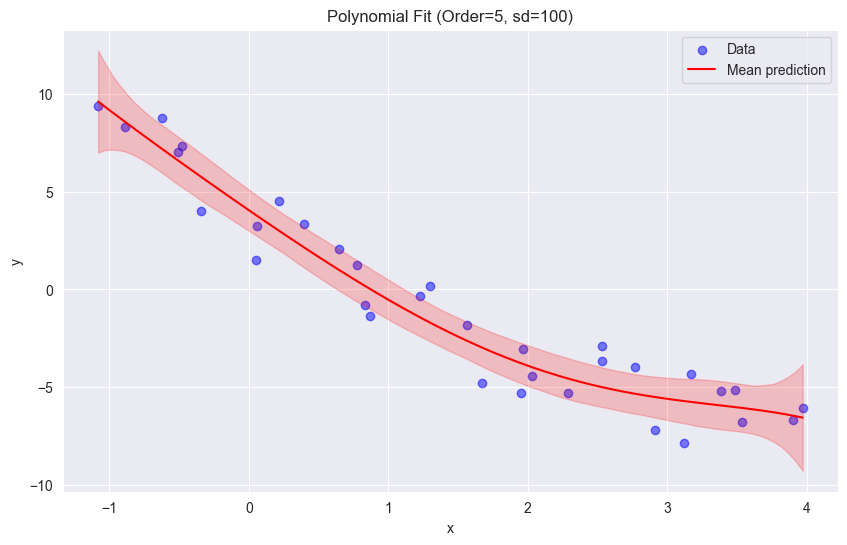

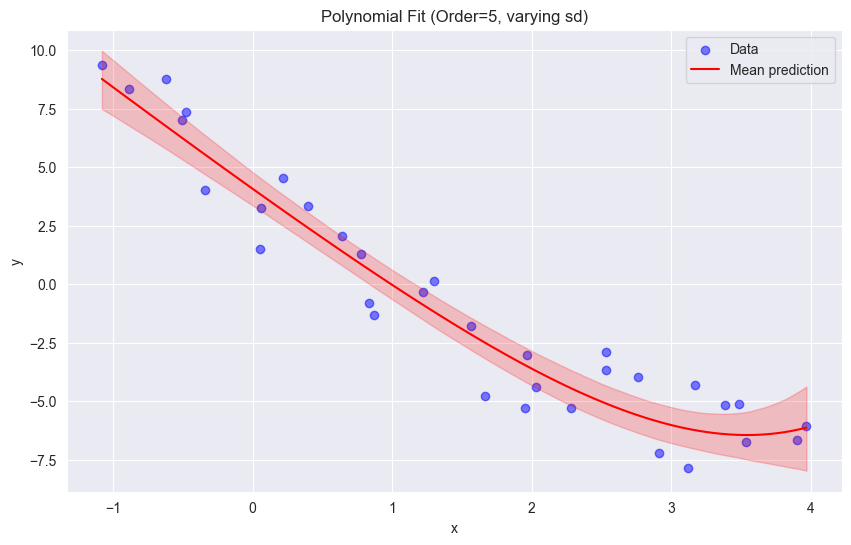

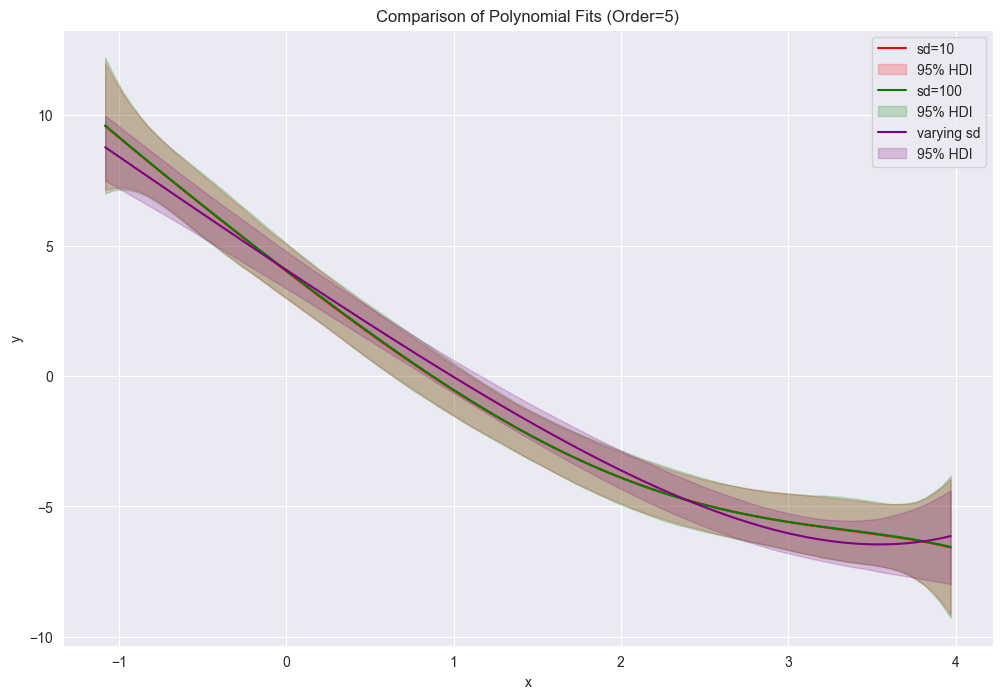


Summary for sd=10:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    -0.001  0.050  -0.098    0.090      0.001    0.001    4683.0    4187.0   
β[0] -1.431  0.251  -1.902   -0.964      0.005    0.004    2354.0    3832.0   
β[1]  0.223  0.637  -0.960    1.474      0.009    0.008    4789.0    4393.0   
β[2]  0.288  2.616  -4.816    5.120      0.059    0.042    1964.0    2998.0   
β[3]  0.466  4.469  -8.029    8.834      0.103    0.073    1887.0    2772.0   
β[4] -0.443  2.296  -4.702    3.885      0.051    0.036    2017.0    2791.0   

      r_hat  
α       1.0  
β[0]    1.0  
β[1]    1.0  
β[2]    1.0  
β[3]    1.0  
β[4]    1.0  

Summary for sd=100:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α     0.002  0.051  -0.091    0.101      0.001    0.001    4391.0    4540.0   
β[0] -1.427  0.279  -1.938   -0.881      0.006    0.004    2304.0    3334.0   
β[1]  0.207  0.659  -1.076    1.412      0.010    0.008    4159.0    3

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Load and prepare data
data = np.loadtxt('date.csv')
x_1 = data[:, 0]
y_1 = data[:, 1]

def create_polynomial_features(x, order):
    x_1p = np.vstack([x**i for i in range(1, order+1)])
    x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
    return x_1s.T

def fit_polynomial(x, y, order, beta_sd):
    x_1s = create_polynomial_features(x, order)
    y_1s = (y - y.mean()) / y.std()
    
    with pm.Model() as model_p:
        # Priors
        α = pm.Normal('α', mu=0, sigma=1)
        β = pm.Normal('β', mu=0, sigma=beta_sd, shape=order)
        ε = pm.HalfNormal('ε', 5)
        
        # Model
        μ = α + pm.math.dot(x_1s, β)
        y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_1s)
        
        # Inference
        trace_p = pm.sample(2000, return_inferencedata=True)
    
    return trace_p, model_p

def plot_polynomial_fit(x, y, trace, model, title, ax=None, color='red', label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot original data if this is the first model
    if label is None:
        ax.scatter(x, y, color='blue', alpha=0.5, label='Data')
    
    # Generate predictions
    x_new = np.linspace(x.min(), x.max(), 100)
    x_new_s = create_polynomial_features(x_new, order)
    
    # Get posterior samples
    α_samples = trace.posterior['α'].values.flatten()
    β_samples = trace.posterior['β'].values.reshape(-1, order)
    
    # Calculate predictions for all posterior samples
    y_pred_samples = []
    for i in range(len(α_samples)):
        y_pred = α_samples[i] + np.dot(x_new_s, β_samples[i])
        y_pred = y_pred * y.std() + y.mean()
        y_pred_samples.append(y_pred)
    
    y_pred_samples = np.array(y_pred_samples)
    
    # Calculate mean prediction and HDI
    mean_pred = np.mean(y_pred_samples, axis=0)
    hdi_lower = np.percentile(y_pred_samples, 2.5, axis=0)
    hdi_upper = np.percentile(y_pred_samples, 97.5, axis=0)
    
    # Plot mean prediction and HDI
    ax.plot(x_new, mean_pred, color=color, label=label if label else 'Mean prediction')
    ax.fill_between(x_new, hdi_lower, hdi_upper, color=color, alpha=0.2, 
                   label='95% HDI' if label else None)
    
    if label is None:
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()
        ax.grid(True)
    
    return ax

# Set order and fit models
order = 5

# Fit all models
print("Fitting models...")
trace_10, model_10 = fit_polynomial(x_1, y_1, order, 10)
trace_100, model_100 = fit_polynomial(x_1, y_1, order, 100)
varying_sd = np.array([10, 0.1, 0.1, 0.1, 0.1])
trace_varying, model_varying = fit_polynomial(x_1, y_1, order, varying_sd)

# Plot individual fits
for name, trace, model in [
    ("sd=10", trace_10, model_10),
    ("sd=100", trace_100, model_100),
    ("varying sd", trace_varying, model_varying)
]:
    plot_polynomial_fit(x_1, y_1, trace, model, f'Polynomial Fit (Order={order}, {name})')

# Create comparison plot
plt.figure(figsize=(12, 8))
ax = plt.gca()
plot_polynomial_fit(x_1, y_1, trace_10, model_10, "", ax=ax, color='red', label='sd=10')
plot_polynomial_fit(x_1, y_1, trace_100, model_100, "", ax=ax, color='green', label='sd=100')
plot_polynomial_fit(x_1, y_1, trace_varying, model_varying, "", ax=ax, color='purple', label='varying sd')
plt.title(f'Comparison of Polynomial Fits (Order={order})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
for name, trace in [("sd=10", trace_10), ("sd=100", trace_100), ("varying sd", trace_varying)]:
    print(f"\nSummary for {name}:")
    print(az.summary(trace, var_names=['α', 'β']))